In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [2]:
os.path.join('Toxicity','train.csv')

'Toxicity/train.csv'

In [3]:
df = pd.read_csv(os.path.join('Toxicity', 'train.csv'))

In [4]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
df.iloc[5]['comment_text']

'"\n\nCongratulations from me as well, use the tools well. \xa0· talk "'

In [6]:
df[df.columns[2:]].iloc[5]

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 5, dtype: int64

In [7]:
from tensorflow.keras.layers import TextVectorization

In [8]:
x = df['comment_text']
y = df[df.columns[2:]].values

In [9]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [10]:
df[df.columns[2:]].values

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [11]:
MAX_FEATURES =  200000        # numbers of words in the vocab

In [12]:
MAX_SEQUENCE_LENGTH = 1800

In [13]:
vectorizer = TextVectorization(max_tokens = MAX_FEATURES,
                               output_sequence_length = MAX_SEQUENCE_LENGTH ,
                               output_mode = 'int')

In [14]:
vectorizer.adapt(x.values)

In [15]:
vectorizer('Hello World, Life is great')

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([288, 263, 306, ...,   0,   0,   0])>

In [16]:
vectorized_text = vectorizer(x.values)

In [17]:
print(vectorized_text.shape)

(159571, 1800)


In [18]:
# MCSHBAP - map, chache, shuffle, batch, prefetch from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)    # helps bottlenecks

In [19]:
batch_x, batch_y = dataset.as_numpy_iterator().next()

In [20]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [21]:
train_generator = train.as_numpy_iterator()

In [22]:
train_generator.next()

(array([[    8,    25,    15, ...,     0,     0,     0],
        [    1,   277, 17599, ...,     0,     0,     0],
        [  972,  5649,     4, ...,     0,     0,     0],
        ...,
        [  140,   246,   379, ...,     0,     0,     0],
        [   65, 17095,    13, ...,     0,     0,     0],
        [  271,     3,    84, ...,     0,     0,     0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout


In [24]:
y[0]

array([0, 0, 0, 0, 0, 0])

In [25]:
model = Sequential()

MAX_FEATURES = 200000  # Example vocabulary size
MAX_SEQUENCE_LENGTH = 1800  # Example maximum length of sequences
# Create the embedding layer
model.add(Embedding(MAX_FEATURES + 1,64))
# Build the model by specifying the input shape
model.build(input_shape=(None, MAX_SEQUENCE_LENGTH))

# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation = 'tanh')))
# Feature extractor Fully connected layer
model.add(Dense(128, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
# Final layer
model.add(Dense(6, activation = 'sigmoid'))

In [26]:
model.compile(loss = 'BinaryCrossentropy', optimizer = 'Adam')

In [35]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1800, 64)       │    12,800,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,699,732 (147.63 MB)

 Trainable params: 12,899,910 (49.21 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,799,822 (98.42 MB)

In [36]:
# history = model.fit(train, epochs = 2, validation_data = val, batch_size=64)

In [4]:
# Save the trained model
model.save('toxic_comment_model.keras')  # Saves in TensorFlow's SavedModel format


In [39]:
# import pandas as pd

# # Extract the training history from the Keras History object
# history_dict = history.history

# # Convert the dictionary to a pandas DataFrame
# history_df = pd.DataFrame(history_dict)

# # Save the DataFrame to a CSV file
# history_df.to_csv('training_history.csv', index=False)


In [40]:
# history.history

In [ ]:
!pip install matplotlib

In [43]:
import pandas as pd
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

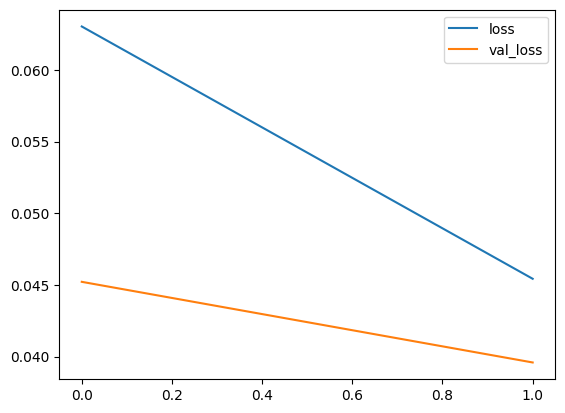

In [44]:
history_df = pd.read_csv('training_history.csv')

# Plot the training history
plt.figure(figsize=(8, 5))
history_df.plot()

# Show the plot
plt.show()

In [45]:
input_text = vectorizer('You freaking suck! I am going to hit you')

In [46]:
input_text

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([   7, 7158,  397, ...,    0,    0,    0])>

In [47]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [48]:
batch = test.as_numpy_iterator().next()

In [49]:
batch_x,batch_y = test.as_numpy_iterator().next()

In [50]:
np.expand_dims(input_text,0)

array([[   7, 7158,  397, ...,    0,    0,    0]])

In [51]:
(model.predict(batch_x) > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [52]:
res = model.predict(np.expand_dims(input_text,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


In [53]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [54]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    # Unpack the batch
    x_true, y_true = batch
    # Make a prediction
    yhat = model.predict(x_true)

    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)


In [58]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8127985000610352, Recall:0.7382880449295044, Accuracy:0.49448344111442566


In [ ]:
!pip install gradio jinja2

In [60]:
import tensorflow as tf
import gradio as gr

/Users/amrutadeokar/CommentToxicity/CommentToxicity/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [61]:
model = tf.keras.models.load_model('toxic_comment_model.h5')

In [62]:
input_str = vectorizer('I hate you!')

In [63]:
res = model.predict(np.expand_dims(input_str, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


In [64]:
res

array([[0.6682106 , 0.01755213, 0.19747953, 0.03899886, 0.27927357,
        0.07595998]], dtype=float32)

In [65]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)

    text = ''
    for idx, col in enumerate(df.columns[2: -1]):
        text += '{}: {}\n'.format(col, results[0][idx] > 0.5)
    return text
                              

In [66]:
interface = gr.Interface(fn = score_comment,
                         inputs = gr.Textbox(lines = 2, placeholder = 'Comment to score'),
                         outputs = 'text')

In [67]:
interface.launch(share = True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://4b2ff924c54da787e4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


In [1]:
from tensorflow.keras.models import load_model

try:
    model = load_model('toxic_comment_model.h5')
    model.summary()  # To confirm the model loaded successfully
except Exception as e:
    print(f"Error: {e}")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1800, 64)       │    12,800,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,899,912 (49.21 MB)

 Trainable params: 12,899,910 (49.21 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)